In [5]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Import the 3 dimensionality reduction methods
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#Unbalanced data
from imblearn.combine import SMOTETomek

#Split data
from sklearn.model_selection import train_test_split

#standardization
from sklearn.preprocessing import StandardScaler

#subplot
from pylab import *

In [6]:
######################################   LOAD CLEANED DATA   ################################
df = pd.read_csv('data/in_CleanedData.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2770409 entries, 0 to 2770408
Data columns (total 9 columns):
step                int64
type                object
amount              float64
balanceSender       float64
balanceReceiver     float64
errorBalanceDest    float64
errorBalanceOrig    float64
noErrors            int64
isFraud             int64
dtypes: float64(5), int64(3), object(1)
memory usage: 190.2+ MB


In [7]:
####################################    DATA PREPROCESSING     ################################
##################################### Categorical Variable ####################################

# --------- OnHot-encoding of labelled data in 'type'  TRANSFER = 1, CASH_OUT = 0
one_hot = pd.get_dummies(df['type'])
df = df.drop('type',axis = 1)
df = df.join(one_hot)


In [8]:
####################################    DATA PREPROCESSING     ################################
  #####################################  Split data ###################################

# ---------- Split data to tarin and target
y_data = df['isFraud']
x_data = df.drop(['isFraud'],axis=1)

#-------------------Split data to training=60% and test=40%
X_train, X_test, Y_train, Y_test=train_test_split(x_data, y_data, test_size=0.4)
p=100*float(sum(x == 1 for x in Y_train))/Y_train.size
q=100*float(sum(x == 1 for x in Y_test))/Y_test.size
r=100*float(sum(x == 1 for x in y_data))/y_data.size

#change output from 0/1 to -1/1
Y_train=mod(Y_train,2)*2-1
Y_test=mod(Y_test,2)*2-1

print("Dataset       : ",y_data.size,'with %.4f'% r,'% fraudulent transactions')
print("Data training : ",Y_train.size,'with %.4f'% p,'% fraudulent transactions')
print("Data test     : ",Y_test.size,'with %.4f'% q,'% fraudulent transactions')


Dataset       :  2770409 with 0.2965 % fraudulent transactions
Data training :  1662245 with 0.2945 % fraudulent transactions
Data test     :  1108164 with 0.2994 % fraudulent transactions


In [9]:
print(sum(x == 1 for x in Y_train))
X_train[:10]

4895


,step,amount,balanceSender,balanceReceiver,errorBalanceDest,errorBalanceOrig,noErrors,CASH_OUT,TRANSFER
1647180,279,338709.20,0.00,691646.33,1.164153e-10,338709.20,0,1,0
1309509,231,62328.64,775606.34,1015843.14,0.000000e+00,0.00,1,1,0
1978486,326,329063.35,0.00,361479.54,0.000000e+00,278183.35,0,1,0
1138044,207,54714.09,0.00,11637327.70,-1.000000e-02,54714.09,0,1,0
245783,22,134860.60,0.00,2027256.93,-1.000000e-02,134860.60,0,1,0
2525259,400,152602.13,0.00,152602.13,0.000000e+00,101069.13,0,0,1
94532,14,590164.70,0.00,1322342.28,-2.328306e-10,590164.70,0,1,0
1350112,235,319334.02,0.00,319334.02,0.000000e+00,308822.02,0,1,0
384720,42,13238.26,0.00,131782.96,-5.094870e+04,13238.26,0,1,0
1679960,282,397084.77,0.00,5030898.15,-1.000000e-02,397084.77,0,0,1


In [ ]:
####################################    DATA PREPROCESSING     ################################
###################################### Unbalanced data ########################################

#---------------------- OverSampling and UnderSampling

subplot(2,1,1)
pd.value_counts(Y_train).plot.bar()
plt.title('Fraud class histogram before SMOTETomek')
plt.xlabel('Class')
plt.ylabel('Frequency')

#---------------------- OverSampling and UnderSampling
start_time = time.time()
smt = SMOTETomek(ratio='auto')
x_train, y_train = smt.fit_sample(X_train, Y_train.ravel())

print("--- Model Predicting in %s seconds ---" % (time.time() - start_time))
print('After OverUnderSampling, the shape of train_X: {}'.format(x_train.shape))

subplot(2,1,2)
pd.value_counts(y_train).plot.bar()
plt.title('Fraud class histogram after TuningSMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')



In [ ]:
#save unbalanced data


we need  2  dimesion to explain 99% of the variance 


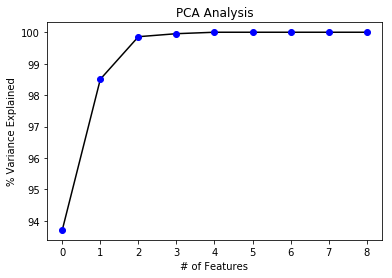

In [29]:
####################################    DATA PREPROCESSING     ################################

#----------------- PCA : singular value decomposition SVD ---------------

# Calculating Eigenvectors and eigenvalues of Cov matirx
mean_vec = np.mean(X_train, axis=0)
cov_mat = np.cov(X_train.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the eigenvalue, eigenvector pair from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)



# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

#plot 
plt.plot(cum_var_exp, 'k',cum_var_exp, 'bo')
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')

# Find the eigenvector beyond which 90% of the data is explained
d=[ n for n,i in enumerate(cum_var_exp) if i>99 ][0]
print('we need ', d,' dimesion to explain 99% of the variance ')
#So, we need 2 eigenvectors to explain 99% of the variance. So, let us reshape our training data matrix into a 42000*228 
#matrix with each column corresponding to the projections onto the eigenvectors.



In [46]:
Y_train[2]

-1

In [ ]:
####################################    DATA PREPROCESSING     ################################

#----------------- PCA : singular value decomposition SVD ---------------
# Call the PCA method with 2 components. 
pca_train = PCA(n_components=d)

pca_train.fit(X_train)
X_train = pca_train.transform(X_train)
print("Data training size", X_train.shape)

plt.scatter(X_train[:, 0], X_train[:, 1],X_train[:], edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')

